In [439]:
import numpy as np
import csv
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [440]:
def plot_througput(data, label, do_plot=True):
    """
    Throughput speed in Mbps
    """
    times = data[:,0]
    throughputs = data[:,1]
    throughputs = np.trim_zeros(throughputs, trim='b')
    times = times[:throughputs.shape[0]]
    throughputs = np.trim_zeros(throughputs, trim='f')
    times = times[times.shape[0] - throughputs.shape[0]:]
        
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, throughputs, label="throughput "+label) 
        ax1.set_title("Throughput vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Mbps')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("throughput vs Time.png", format="png")
        fig.show()
    return np.mean(throughputs), np.percentile(throughputs, 99)

In [441]:
def plot_cwnd(data, label, do_plot=True):
    times = data[:,0]
    throughputs = data[:,1]
    cwnds = data[:,2]
    throughputs = np.trim_zeros(throughputs, trim='b')
    times = times[:throughputs.shape[0]]
    cwnds = cwnds[:throughputs.shape[0]]
    
    throughputs = np.trim_zeros(throughputs, trim='f')
    times = times[times.shape[0] - throughputs.shape[0]:]
    cwnds = cwnds[cwnds.shape[0] - throughputs.shape[0]:]
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, cwnds, label="cwnd "+label) 
        ax1.set_title("Cwnd vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Packets')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("cwnd vs Time.png", format="png")
        fig.show()

In [442]:
def plot_queue_size(data, label, do_plot=True):
    
    # http://www.mathcs.emory.edu/~cheung/Courses/558-old/Syllabus/90-NS/trace.html
    # Columns are: Time(s)-fromNode-toNode-SizeB-SizePack-Packsarrived(in interval)
    # -departed - dropped -3: same in bytes
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    q_size_P = np.trim_zeros(q_size_P, trim='b')
    times = times[:q_size_B.shape[0]]
    
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    q_size_P = np.trim_zeros(q_size_P, trim='f')
    
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    if do_plot:
        fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
        ax1.plot(times, q_size_B, label="q_size in bytes "+label) 
        ax1.set_title("Q size vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Bytes')
        ax1.set_xlabel('Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        ax2.plot(times, q_size_P, label="q_size in packets "+label) 
        ax2.set_title("Q size vs Time")
        ax2.legend(loc='upper left')
        ax2.set_ylabel('Packets')
        ax2.set_xlabel('Seconds')
        ax2.grid(which='major', linestyle="-")
        ax2.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Q_size vs Time.png", format="png")
        fig.show()
    #avg_q_occup = np.mean(q_size_B)
    #print("Mon_mean: " + str(avg_q_occup))
    q_size_B = q_size_B/1000.0
    return np.mean(q_size_B), np.mean(q_size_P), np.percentile(q_size_B,99), np.percentile(q_size_P, 99)

In [443]:
def plot_queuing_time(data, label, link_speed, do_plot=True):
    """
    Link speed in Gbps
    """
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    times = times[:q_size_B.shape[0]]
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    link_speed = link_speed * 1000.0 * 1000.0 * 1000.0
    q_time = q_size_B/(link_speed/8.0) * 1000.0 * 1000.0
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, q_time, label="queuing delay "+label) 
        ax1.set_title("Queuing delay vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Queuing miliseconds')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(q_time), np.percentile(q_time, 99)

In [444]:
def print_results():
    print("Mean Q length in Kbytes {0} and in packets {1}\n\
    99th percentile in Kbytes {2} and in packets {3}\n".format(bytes_mean, pkts_mean, bytes_99, pkts_99))
    print("Mean delay in us {0} and 99th percentile delay in us {1}".format(delay_mean, delay_99))
    print("Mean thrpt in Mbps {0} and 99th percentile thrpt in Mbps {1}".format(thrpt_mean, thrpt_99))    

In [445]:
thrpt_list = [None]*4
delay_mean_list = [None]*4
delay_99_list = [None]*4

# TCP

Mean Q length in Kbytes 128.11275597553976 and in packets 200.1761815878975
    99th percentile in Kbytes 319.34003199995504 and in packets 498.96879999992984

Mean delay in us 1024.9020478043183 and 99th percentile delay in us 2554.720255999641
Mean thrpt in Mbps 754.436911487759 and 99th percentile thrpt in Mbps 950.4


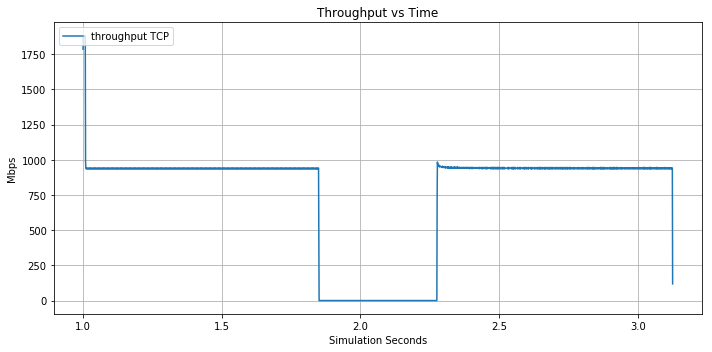

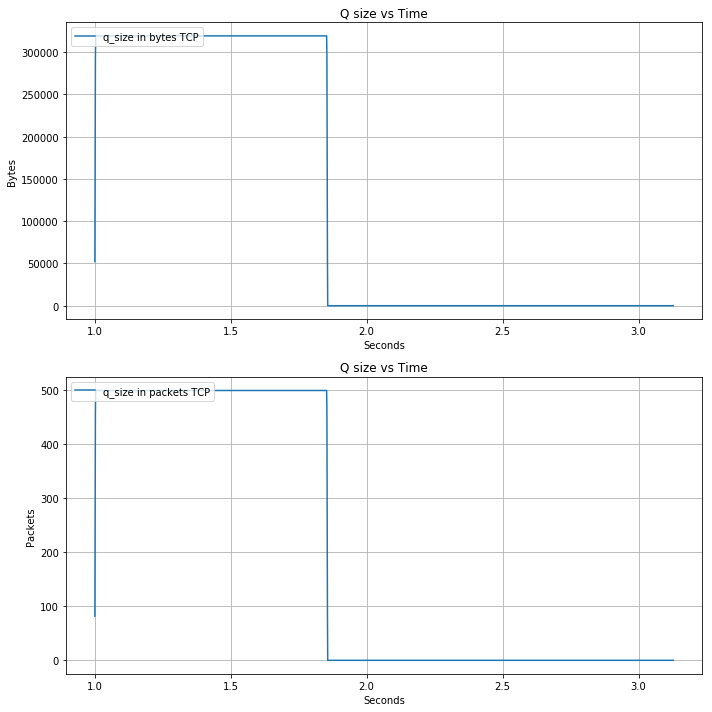

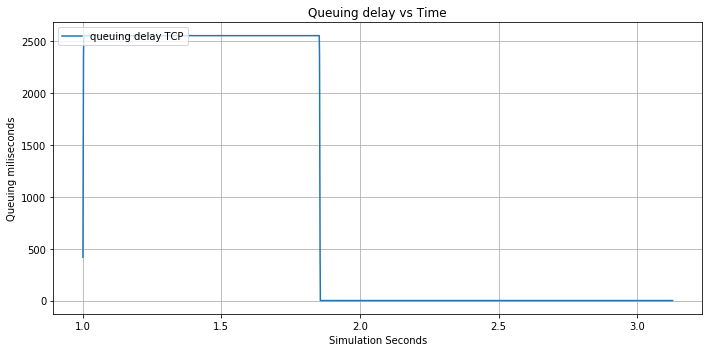

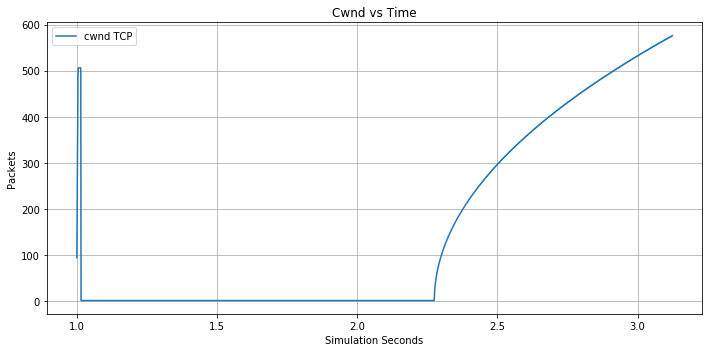

In [446]:
label = "TCP"
q_mon = np.genfromtxt("q_mon|"+label+"|2", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|2", delimiter=",")

thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
plot_cwnd(thrpts,label)
print_results()

thrpt_list[0] = thrpt_mean
delay_mean_list[0] = delay_mean
delay_99_list[0] = delay_99


# DCTCP - 30K

Mean Q length in Kbytes 15.05048448213972 and in packets 23.516414575106637
    99th percentile in Kbytes 15.343450623951686 and in packets 23.974141599924508

Mean delay in us 120.40387585711775 and 99th percentile delay in us 122.74760499161347
Mean thrpt in Mbps 937.3169302870533 and 99th percentile thrpt in Mbps 969.6


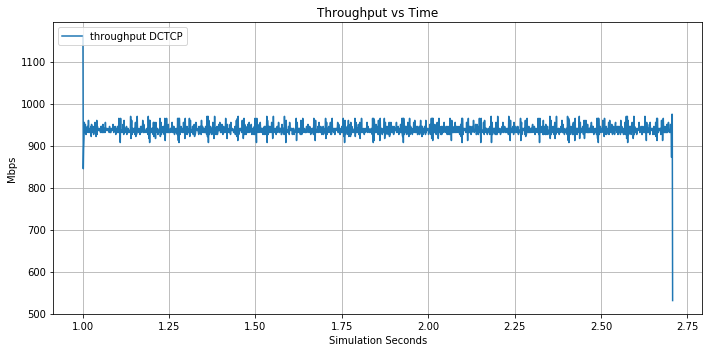

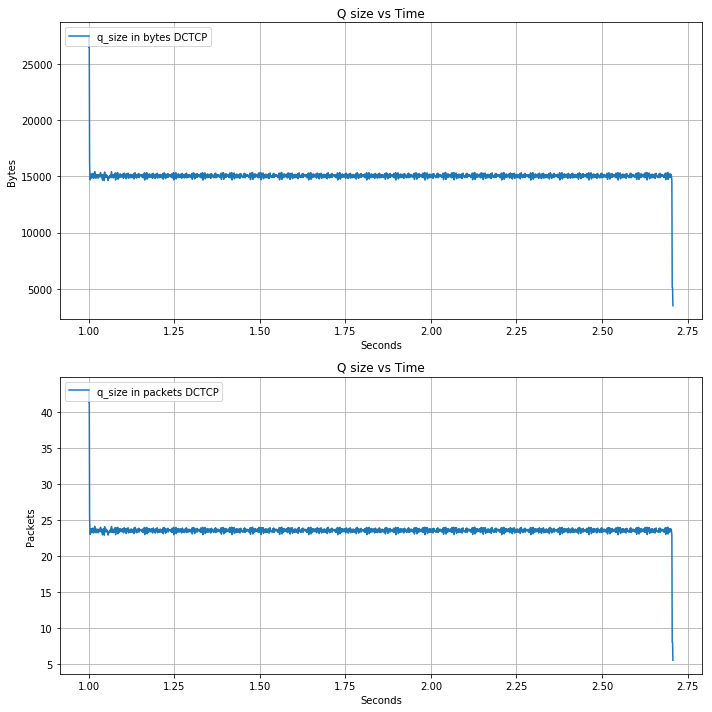

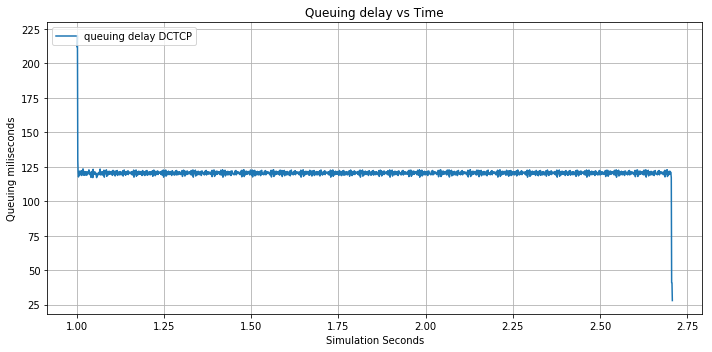

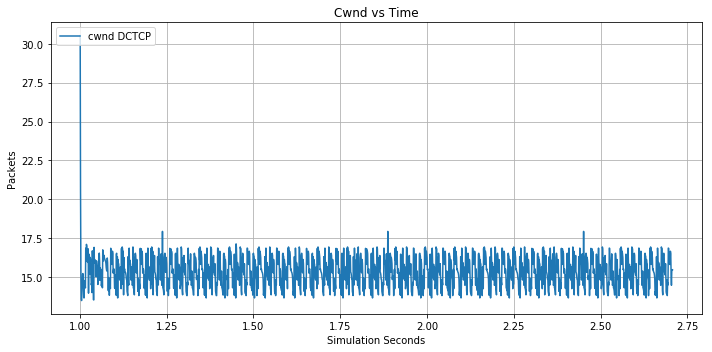

In [447]:
label = "DCTCP"
q_mon = np.genfromtxt("q_mon|"+label+"|2", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|2", delimiter=",")

thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
plot_cwnd(thrpts,label)

print_results()

thrpt_list[1] = thrpt_mean
delay_mean_list[1] = delay_mean
delay_99_list[1] = delay_99

Mean Q length in Kbytes 15.05048448213972 and in packets 23.516414575106637
    99th percentile in Kbytes 15.343450623951686 and in packets 23.974141599924508

Mean delay in us 120.40387585711775 and 99th percentile delay in us 122.74760499161347
Mean thrpt in Mbps 937.3169302870533 and 99th percentile thrpt in Mbps 969.6


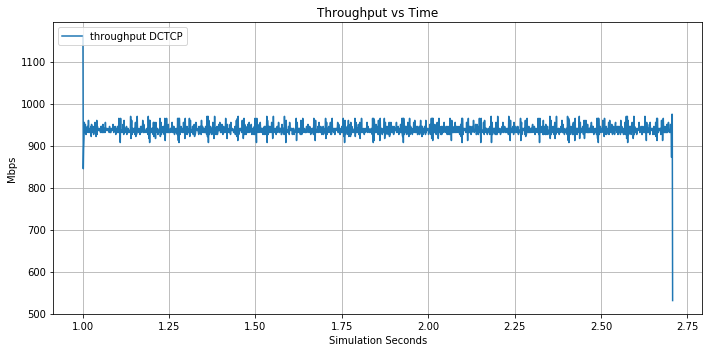

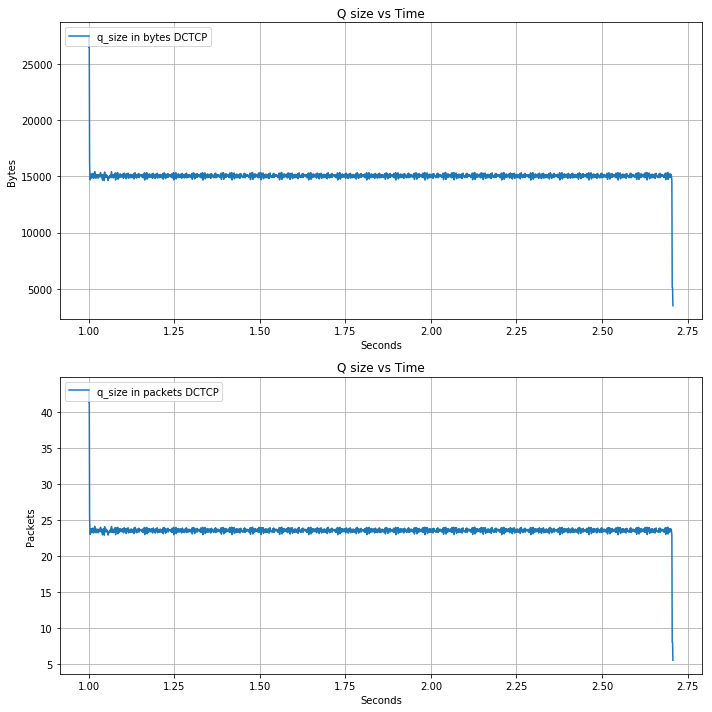

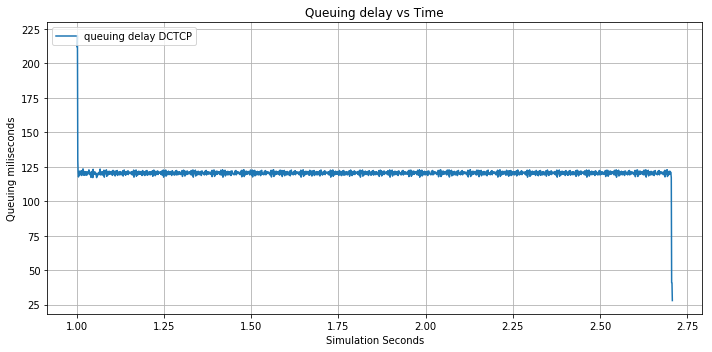

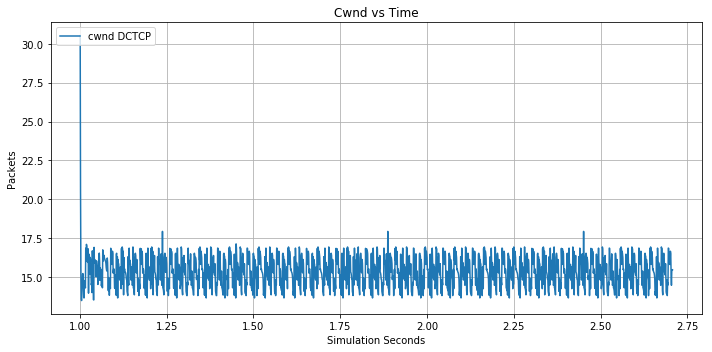

In [448]:
label = "DCTCP"
q_mon = np.genfromtxt("q_mon|"+label+"|2", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|2", delimiter=",")

thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
plot_cwnd(thrpts,label)

print_results()

# DCTCP - 6K + Pacing

Mean Q length in Kbytes 3.4938678511817542 and in packets 5.459186144906145
    99th percentile in Kbytes 3.760732504764352 and in packets 5.8761445386943

Mean delay in us 27.950942809454034 and 99th percentile delay in us 30.085860038114816
Mean thrpt in Mbps 936.2200117027502 and 99th percentile thrpt in Mbps 964.8000000000001


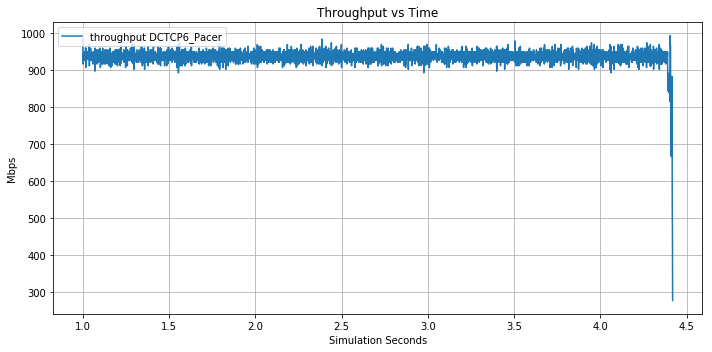

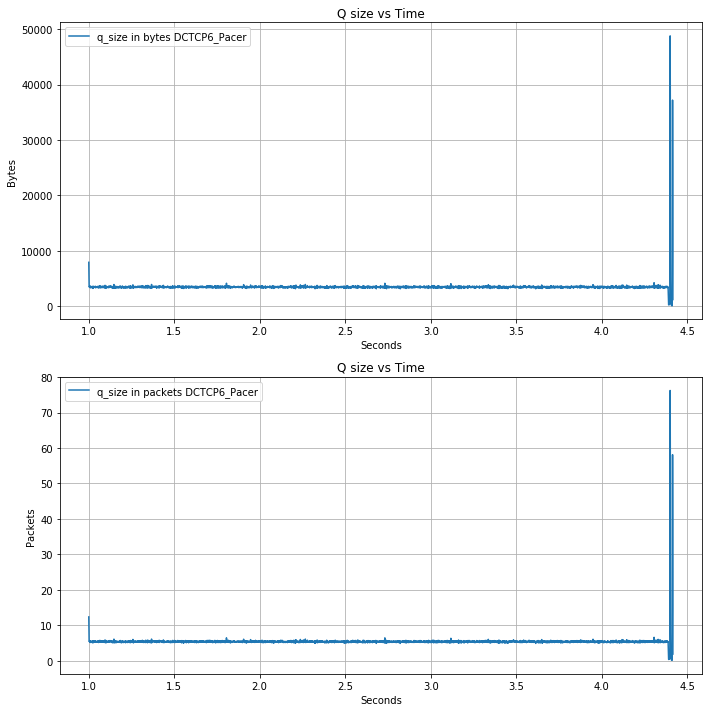

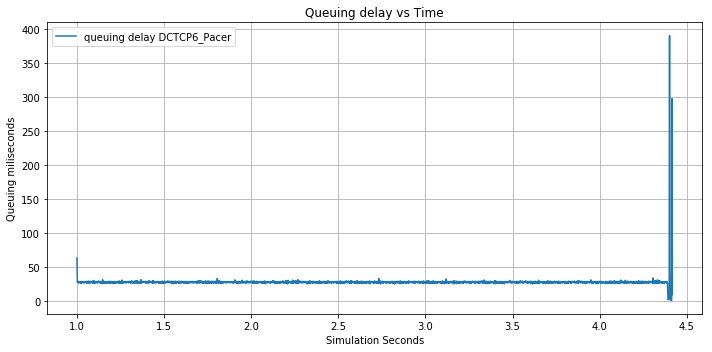

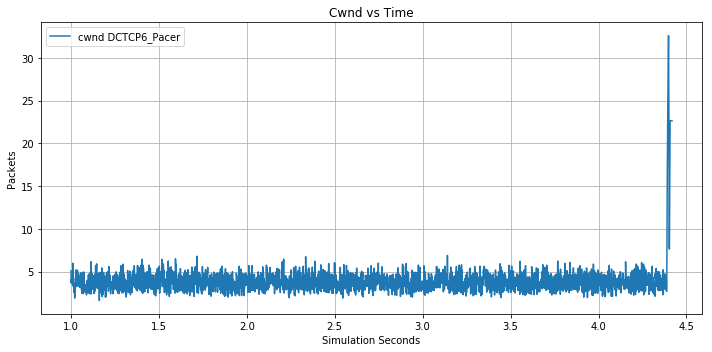

In [449]:
label = "DCTCP6_Pacer"
q_mon = np.genfromtxt("q_mon|"+label+"|4", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|4", delimiter=",")

thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
plot_cwnd(thrpts,label)

print_results()

thrpt_list[2] = thrpt_mean
delay_mean_list[2] = delay_mean
delay_99_list[2] = delay_99

Mean Q length in Kbytes 3.828742184475281 and in packets 5.982422895119879
    99th percentile in Kbytes 4.068840071853494 and in packets 6.357562612271084

Mean delay in us 30.629937475802247 and 99th percentile delay in us 32.55072057482795
Mean thrpt in Mbps 935.4536950420954 and 99th percentile thrpt in Mbps 964.8000000000001


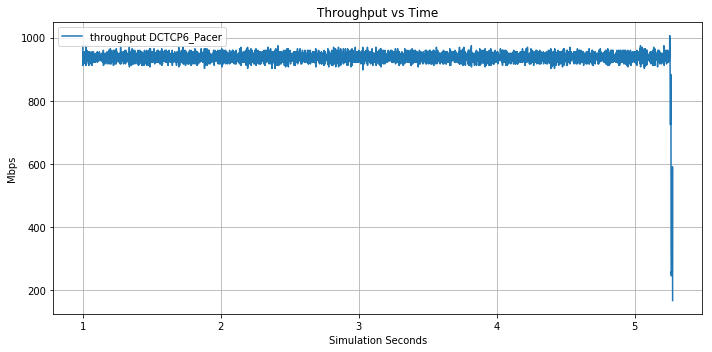

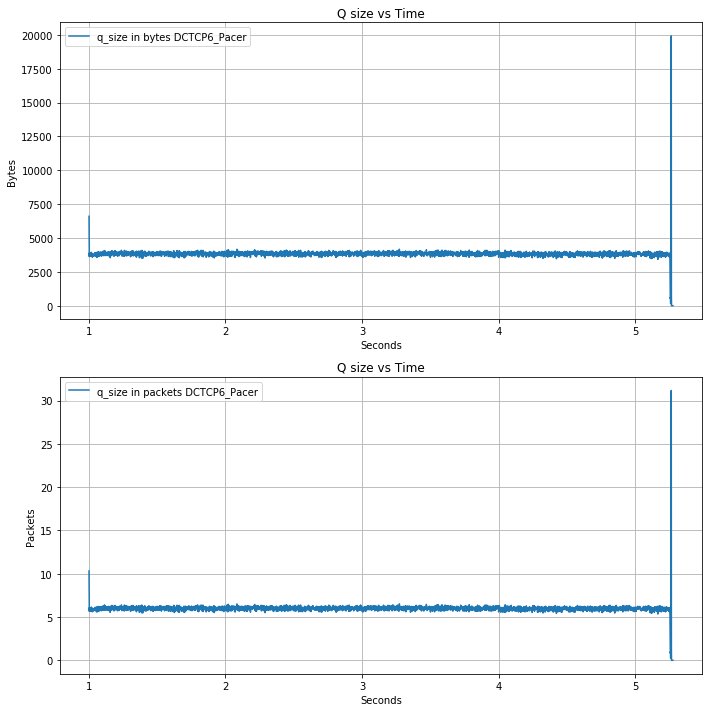

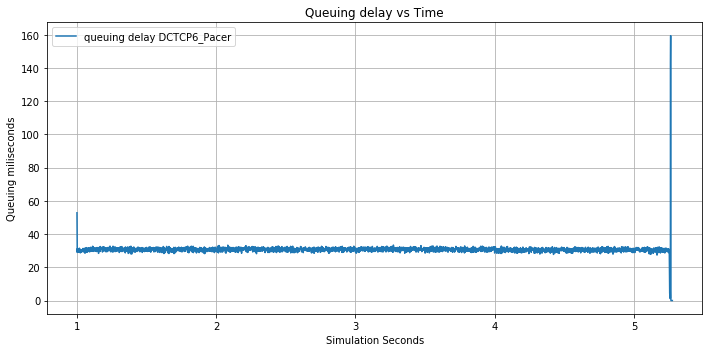

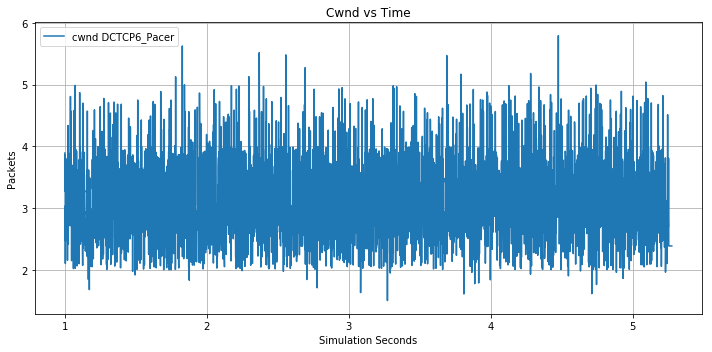

In [450]:
label = "DCTCP6_Pacer"
q_mon = np.genfromtxt("q_mon|"+label+"|5", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|5", delimiter=",")

thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
plot_cwnd(thrpts,label)

print_results()

# DCTCP + PQ950 + Pacing

Mean Q length in Kbytes 0.3085834829234656 and in packets 0.4821629957072414
    99th percentile in Kbytes 0.330782165347422 and in packets 0.5168471333553468

Mean delay in us 2.468667863387725 and 99th percentile delay in us 2.646257322779376
Mean thrpt in Mbps 869.0928843020098 and 99th percentile thrpt in Mbps 878.4000000000001


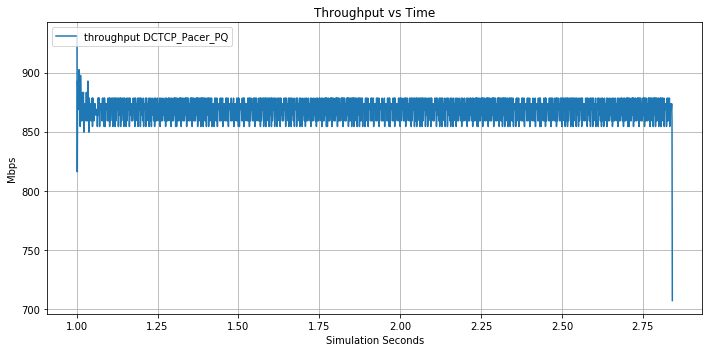

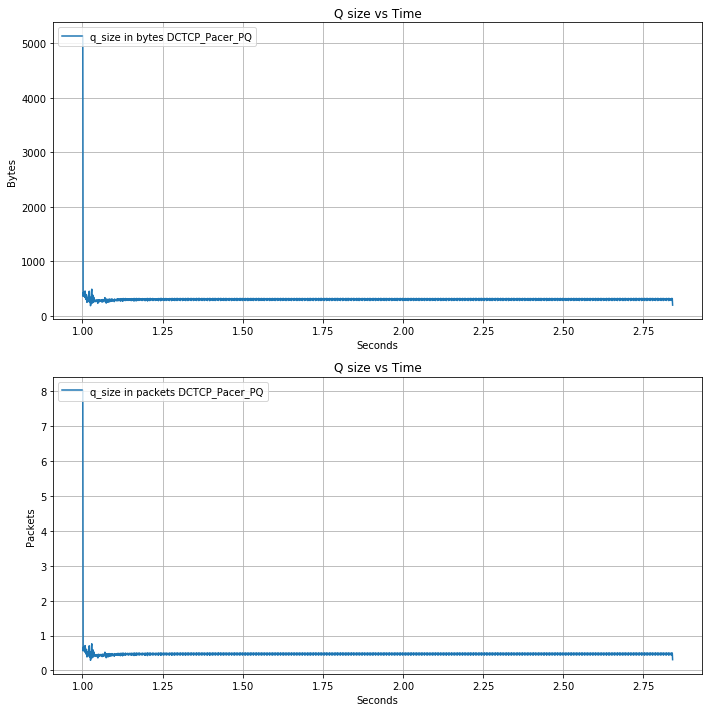

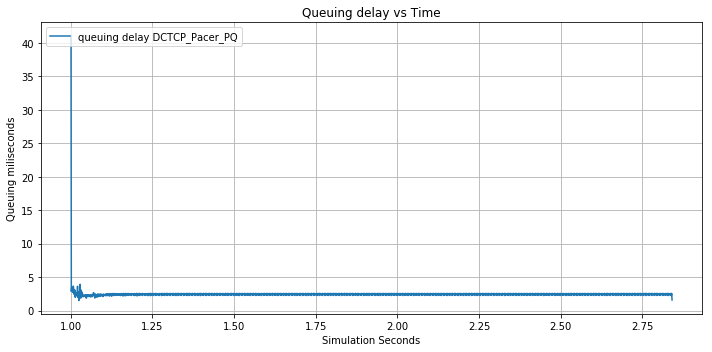

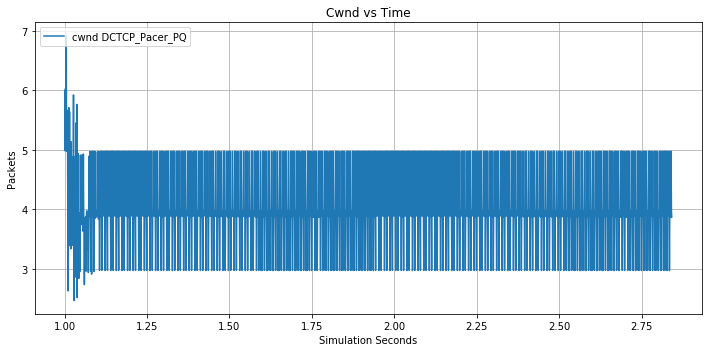

In [451]:
label = "DCTCP_Pacer_PQ"
q_mon = np.genfromtxt("q_mon|"+label+"|2", delimiter=" ")
thrpts =np.genfromtxt("thrpt_mon|"+label+"|2", delimiter=",")
thrpt_mean, thrpt_99 = plot_througput(thrpts, label)
bytes_mean, pkts_mean, bytes_99, pkts_99 = plot_queue_size(q_mon, label)
delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1)
plot_cwnd(thrpts,label)

print_results()

thrpt_list[3] = thrpt_mean
delay_mean_list[3] = delay_mean
delay_99_list[3] = delay_99

# AGGREAGTES

In [452]:
print(delay_mean_list)
print(delay_99_list)
print(thrpt_list)

[1024.9020478043183, 120.40387585711775, 27.950942809454034, 2.468667863387725]
[2554.720255999641, 122.74760499161347, 30.085860038114816, 2.646257322779376]
[754.436911487759, 937.3169302870533, 936.2200117027502, 869.0928843020098]


In [453]:
nums_flows = [2,3,4,5,6,7,8]
labels = ["TCP","DCTCP","DCTCP6_Pacer","DCTCP_Pacer_PQ"]
delay_results = np.zeros(shape=(len(labels), len(nums_flows)))
delay_results_99 = np.zeros(shape=(len(labels), len(nums_flows)))
throughput_results = np.zeros(shape=(len(labels), len(nums_flows)))

for col,num_flows in enumerate(nums_flows):
    for row,label in enumerate(labels):
        file_suffix = label+"|"+str(num_flows)
        print(file_suffix)
        q_mon = np.genfromtxt("q_mon|"+file_suffix, delimiter=" ")
        thrpts =np.genfromtxt("thrpt_mon|"+file_suffix, delimiter=",")

        thrpt_mean, thrpt_99 = plot_througput(thrpts, label, do_plot=False)
        delay_mean, delay_99 = plot_queuing_time(q_mon, label, 1, do_plot=False)
        
        delay_results[row,col] = delay_mean
        delay_results_99[row,col] = delay_99
        throughput_results[row,col] = thrpt_mean

print(delay_results)
print(delay_results_99)
print(throughput_results)

TCP|2
DCTCP|2
DCTCP6_Pacer|2
DCTCP_Pacer_PQ|2
TCP|3
DCTCP|3
DCTCP6_Pacer|3
DCTCP_Pacer_PQ|3
TCP|4
DCTCP|4
DCTCP6_Pacer|4
DCTCP_Pacer_PQ|4
TCP|5
DCTCP|5
DCTCP6_Pacer|5
DCTCP_Pacer_PQ|5
TCP|6
DCTCP|6
DCTCP6_Pacer|6
DCTCP_Pacer_PQ|6
TCP|7
DCTCP|7
DCTCP6_Pacer|7
DCTCP_Pacer_PQ|7
TCP|8
DCTCP|8
DCTCP6_Pacer|8
DCTCP_Pacer_PQ|8
[[1.02490205e+03 1.93849698e+03 1.95615655e+03 1.99016930e+03
  1.99086436e+03 2.00101829e+03 2.01088387e+03]
 [1.20403876e+02 1.22148924e+02 1.23401254e+02 1.24315540e+02
  1.25085853e+02 1.25661359e+02 1.26643481e+02]
 [2.59728002e+01 2.68324585e+01 2.79509428e+01 3.06299375e+01
  3.05550395e+01 4.07954458e+01 5.10374351e+01]
 [2.46866786e+00 8.92917611e-01 1.00900186e+01 2.03279881e+01
  3.05625594e+01 4.08010272e+01 5.10402609e+01]]
[[2.55472026e+03 2.55471976e+03 2.55472026e+03 2.55472026e+03
  2.55472026e+03 2.55472026e+03 2.55472026e+03]
 [1.22747605e+02 1.25712097e+02 1.27152425e+02 1.28435175e+02
  1.30023178e+02 1.31608413e+02 1.32950622e+02]
 [2.78642617e+01 

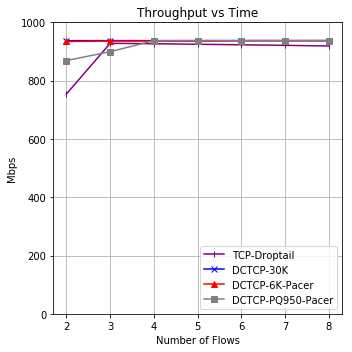

In [454]:

plot_labels = ["TCP-Droptail", "DCTCP-30K", "DCTCP-6K-Pacer", "DCTCP-PQ950-Pacer"]
markers = ["|","x","^","s"]
colors = ["purple", "blue", "red", "gray"]
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
for i,lbel in enumerate(plot_labels):
    ax1.plot(nums_flows, throughput_results[i,:], label=lbel, marker=markers[i], color=colors[i]) 
ax1.set_title("Throughput vs Time")
ax1.legend(loc='lower right')
ax1.set_ylabel('Mbps')
ax1.set_xlabel('Number of Flows')
ax1.grid(which='major', linestyle="-")
ax1.grid(which='minor', linestyle='--')
ax1.set_ylim(bottom=0, top=1000)

fig.tight_layout()   

fig.savefig("throughput final.png", format="png")
fig.show()

In [455]:
def plot_delays(x,y,yerr=None):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    #ax1.plot(x, y, label="Delay") 
    
    for i,lbel in enumerate(plot_labels):
        filler = np.zeros(shape=(yerr.shape[1],1))
        yerr_tmp = yerr[i,:] - y[i,:]
        yerr_tmp=np.concatenate((filler, yerr_tmp.reshape(yerr.shape[1],1)), axis=1).T
        print(y[i,:])
        print(yerr_tmp)
        print("-----------------")
        ax1.errorbar(x, y[i,:], yerr=yerr_tmp, fmt='none', capsize=2, color = colors[i])
        ax1.semilogy(x, y[i,:], label=lbel, marker=markers[i], color = colors[i])
    ax1.set_title("Delay vs Time")
    ax1.legend(loc='lower right')
    
    ax1.set_ylabel('us')
    ax1.set_xlabel('Number of Flows')
    ax1.grid(which='major', linestyle="-")
    ax1.grid(which='minor', linestyle='--')

    fig.tight_layout()  
    fig.show()

[1024.9020478  1938.49697848 1956.15655387 1990.16929572 1990.86435562
 2001.01829481 2010.88386605]
[[   0.            0.            0.            0.            0.
     0.            0.        ]
 [1529.8182082   616.22277781  598.56370214  564.55096028  563.85590038
   553.70196119  543.83638995]]
-----------------
[120.40387586 122.14892396 123.40125391 124.31553968 125.08585303
 125.66135869 126.643481  ]
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [2.34372913 3.5631733  3.75117108 4.11963574 4.93732517 5.94705407
  6.30714145]]
-----------------
[25.97280022 26.83245849 27.95094281 30.62993748 30.55503951 40.79544578
 51.03743512]
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [1.89146151 2.76379532 2.13491723 1.9207831  0.00521649 0.00481022
  0.00282088]]
-----------------
[ 2.46866786  0.89291761 10.09001865 20.32798806 30.56255937 40.80102724
 51.0402609 ]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+0

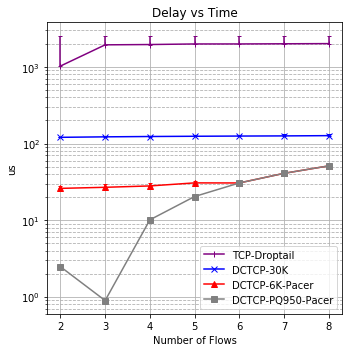

In [456]:
plot_delays(nums_flows, delay_results, delay_results_99)